In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from isaac.constants import FORCE_CLASS_COLS, MASS_CLASS_COLS, BASIC_TRAINING_COLS, PUCK_SQUARE_DISTANCES, PUCK_ANGLE_FEATURES
from isaac.training import evaluate_saved_model
from isaac.visualization import plot_lineplot_with_paper_style, plot_confusion_matrix_given_predicted_and_test_loader
from isaac.models import MultiBranchModel

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from isaac.utils import get_cuda_device_if_available
device = get_cuda_device_if_available()
print(device)

cuda:0


In [3]:
question_type = "mass"
directory = "multibranch_plots/"
stats = pd.read_hdf(directory+"stats.h5")

In [4]:
stats.head()

,Epoch,Mass Loss,Force Loss,Mass Train Accuracy,Mass Val Accuracy,Force Train Accuracy,Force Val Accuracy,seed
0,0,1.105091,1.104568,33.400000,33.4,34.371429,34.0,0
1,1,1.101873,1.099507,35.400000,31.0,37.771429,34.6,0
2,2,1.100093,1.085982,36.057143,34.2,43.800000,41.6,0
3,3,1.098205,1.003010,35.828571,34.6,46.285714,46.6,0
4,4,1.098734,0.921453,38.342857,36.4,50.800000,48.6,0


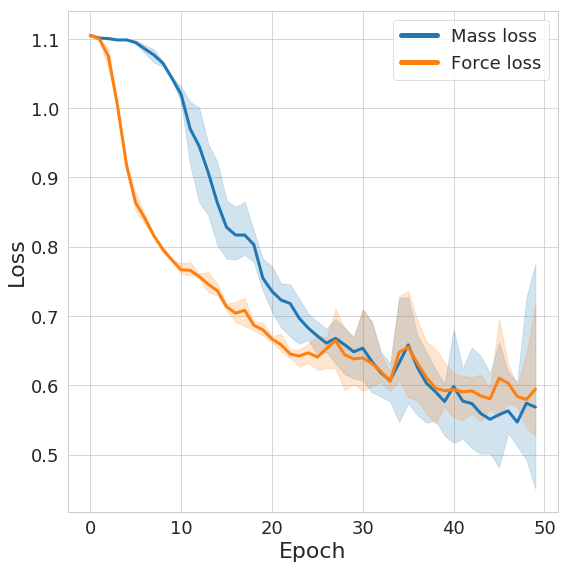

In [5]:
ax = plot_lineplot_with_paper_style(None, x="Epoch", y="Mass Loss", markers=False, data=stats, linewidth=3, label="Mass loss")
ax = plot_lineplot_with_paper_style(None, x="Epoch", y="Force Loss", markers=False, data=stats, linewidth=3, label="Force loss", ax=ax)
plt.ylabel("Loss")
plt.savefig(directory+"losses.pdf")

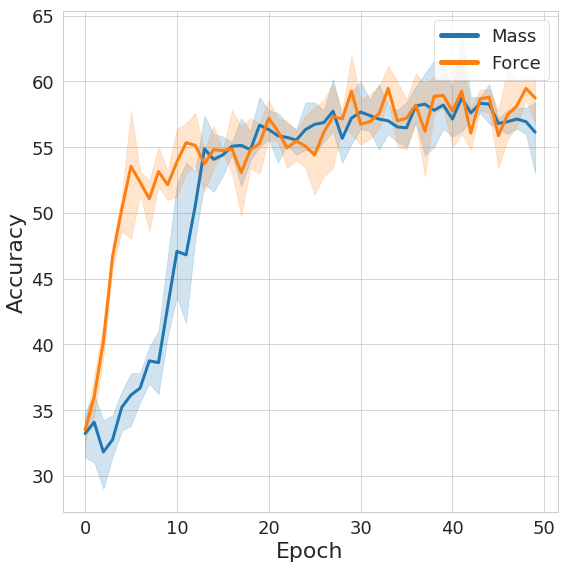

In [6]:
ax = plot_lineplot_with_paper_style(None, x="Epoch", y="Mass Val Accuracy", data=stats, label="Mass")
ax = plot_lineplot_with_paper_style(None, x="Epoch", y="Force Val Accuracy", data=stats, label="Force", ax=ax)
plt.ylabel("Accuracy")
plt.savefig(directory+"accuracies.pdf")

  0%|          | 0/260 [00:00<?, ?it/s]

Model's accuracy on test set: [59.  56.8]


100%|██████████| 260/260 [00:00<00:00, 730.71it/s]


Model's accuracy on test set: [53.46153846 54.61538462]


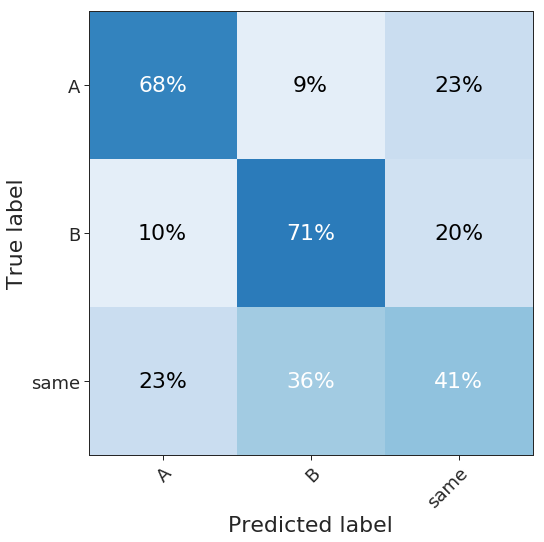

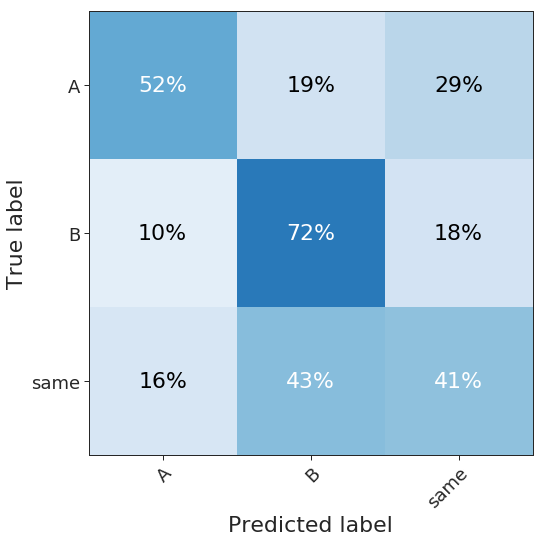

In [7]:
model_path = "models/passive_mass_dual_model.pt"
network_dims = (len(BASIC_TRAINING_COLS), 25, 3)

question_type = "mass"
paths = ["multibranch_plots/test_data_"+question_type+"_cm.pdf",
         "multibranch_plots/neils_data_"+question_type+"_cm.pdf"]

training_columns = BASIC_TRAINING_COLS
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
scaler_path = "scalers/passive_dual_scaler.sk"


for test_dataset_path, plot_path in zip(["data/test_passive_trials.h5", "data/passive_trials_exp1.h5"],
                                               paths):
    
    accuracy, predicted, test_loader = evaluate_saved_model(model_path, network_dims, test_dataset_path,
                                                            training_columns, class_columns, scaler_path=scaler_path, 
                                                            arch=MultiBranchModel, multiclass=True, 
                                                            device=device, return_test_loader=True, seq_start=None,
                                                            seq_end=1800, step_size=3)
                                                            
    multiclass_index = 0
    mass_accuracy = accuracy[multiclass_index]
    mass_predicted = predicted[:, multiclass_index]
    
    ax = plot_confusion_matrix_given_predicted_and_test_loader(mass_predicted, test_loader, MASS_CLASS_COLS, 
                                                               save_plot_path=plot_path, multiclass_index=multiclass_index)

  0%|          | 0/260 [00:00<?, ?it/s]

Model's accuracy on test set: [55.6 59.3]


100%|██████████| 260/260 [00:00<00:00, 671.88it/s]


Model's accuracy on test set: [48.07692308 55.76923077]


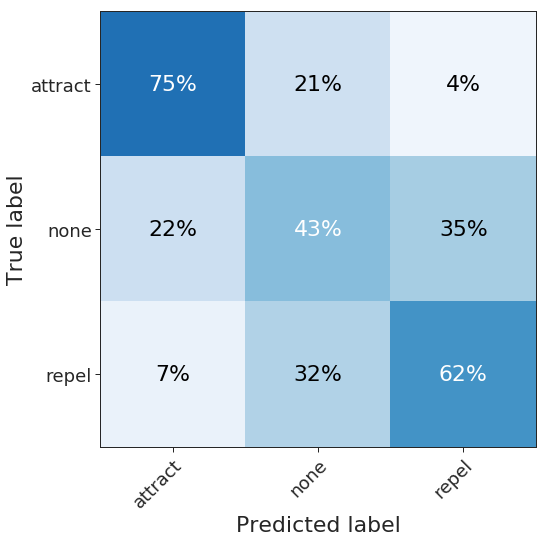

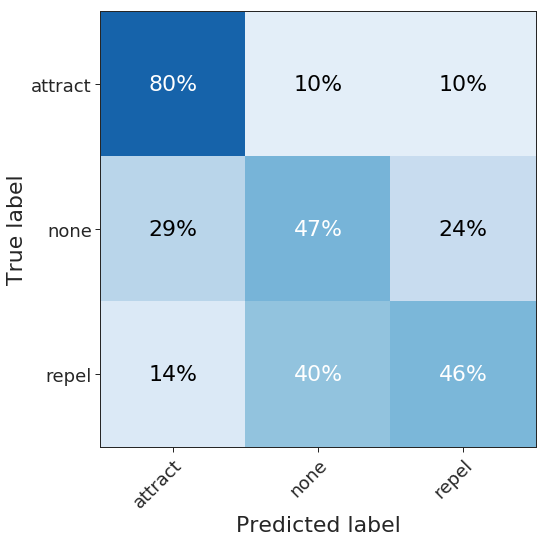

In [8]:
model_path = "models/passive_force_dual_model.pt"
network_dims = (len(BASIC_TRAINING_COLS), 25, 3)

question_type = "force"
paths = ["multibranch_plots/test_data_"+question_type+"_cm.pdf",
         "multibranch_plots/neils_data_"+question_type+"_cm.pdf"]

training_columns = BASIC_TRAINING_COLS
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
scaler_path = "scalers/passive_dual_scaler.sk"


for test_dataset_path, plot_path in zip(["data/test_passive_trials.h5", "data/passive_trials_exp1.h5"],
                                               paths):
    
    accuracy, predicted, test_loader = evaluate_saved_model(model_path, network_dims, test_dataset_path,
                                                            training_columns, class_columns, scaler_path=scaler_path, 
                                                            arch=MultiBranchModel, multiclass=True, 
                                                            device=device, return_test_loader=True, seq_start=None,
                                                            seq_end=1800, step_size=3)
                                                            
    multiclass_index = 1
    force_accuracy = accuracy[multiclass_index]
    force_predicted = predicted[:, multiclass_index]
    
    ax = plot_confusion_matrix_given_predicted_and_test_loader(force_predicted, test_loader, FORCE_CLASS_COLS, 
                                                               save_plot_path=plot_path, multiclass_index=multiclass_index)